In [15]:
import pandas as pd
import numpy as np


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Prediction
import nltk
import re
import itertools

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier # Validation



from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
# Data prepping
from sklearn.preprocessing import LabelEncoder

print("Libraries imported.")
from sklearn.dummy import DummyClassifier # Validation
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
import math, time, random, datetime
pd.set_option('display.max_columns', 50)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

Libraries imported.


In [16]:
data = pd.read_csv('globalterrorismdb_0617dist.csv', encoding='ISO-8859-1')
print("Data loaded.")

Data loaded.


In [17]:
data_columns = [
    
    'eventid', # Unique ID for a row. No analytic or predictive power, but used in some plotting functions.
    
    # ===== Spatio-Temporal Variables =====
    # The names of these variables speak for themselves;
    # where in time and space was the act of terrorism committed?
                'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
    # ===== Binary Variables (1 -> yes or 0 -> no) ===== 
                'extended', # Did the duration of the incident extend 24 hours?
                'vicinity', # Did the incident occur in the immediate vicinity of the city? Is 0 for IN city.
                'crit1', 'crit2', 'crit3', # The incident meets the criterion (1, 2, 3), described in the introduction.
                'doubtterr', # Is there doubt to wether the attack is an act of terrorism?
                'multiple', # Is this incident connected to other incident(s)? !! Consistently available since 1997 !!
                'success', # Has the attack reached its goal? Depends on type of attack.
                'suicide', # Did the perpetrator intend to escape alive?
                'claimed', # Was the attack claimed by an organised group?
                'property', # Is there evidence of property damage from the incident?
                'ishostkid', # Were there victims taken hostage or kidnapped?
    
    # ===== Continuous Variables =====
                'nkill', # Amount of confirmed kills.
                'nwound', # Amount of confirmed wounded.
    # ===== Categorical variables =====
                'country_txt', # Name of country.
                'region', # Region id.
                'region_txt', # Name of region.
                'attacktype1_txt', # Of what type was the attack? I.e. assassination, bombing or kidnapping.
                'targtype1_txt', # What target did the attack have? I.e. business, government or police.
                'natlty1_txt', # Nationality of the target.
                'weaptype1_txt', # What weapon was used?
    
    # ===== Descriptive Variables =====
                'target1', # Description of specific target, if applicable.
                'gname', # Name of the organized group, if applicable.
                'summary', # Summary of the attack.
    
]

In [18]:
#Cleaning the data
data = data.loc[:, data_columns] # Only keep described columns.

# Random acts of violence and other outliers should not be part of the data.
# Thus, restrict the set the only attacks where the terrorism motive is certain.
data = data[(data.crit1 == 1) & (data.crit2 == 1) & (data.crit3 == 1) & (data.doubtterr == 0)]

# Weapontype column contains very long name for vehicle property -> shorten.
data.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

# Replace -9 (unknown) values with 0 (no). -9 values are much more likely to be false than true.
data.iloc[:,[6, 15, 16, 17]] = data.iloc[:,[6, 15, 16, 17]].replace(-9,0)

# Some values in the claimed category are 2 (should be 0 or 1).
# Assume these were input mistakes and set 2 to 1.
data.claimed.replace(2,1, inplace = True)

# Ensure consistent values and make everything lowercase.
data.target1 = data.target1.str.lower()
data.gname = data.gname.str.lower()
data.summary = data.summary.str.lower()    
data.target1 = data.target1.fillna('unknown').replace('unk','unknown')

# Some nwound and nkill are NaN. Replace them with median.
data.nkill = np.round(data.nkill.fillna(data.nkill.median())).astype(int) 
data.nwound = np.round(data.nwound.fillna(data.nwound.median())).astype(int) 

# Database only reports victims as nkill and nwound. Combine these into ncasualties column.
# Also add has_casualties column.
data['ncasualties'] = data['nkill'] + data['nwound']
data['has_casualties'] = data['ncasualties'].apply(lambda x: 0 if x == 0 else 1)

print("Data cleaned and prepared.")

Data cleaned and prepared.


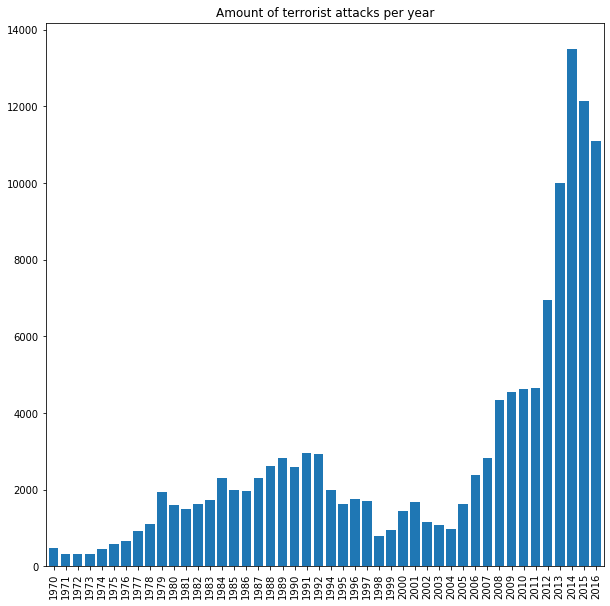

In [19]:
# Data exploration
barplot = pd.value_counts(data['iyear'])\
.sort_index()\
.plot\
.bar(width=0.8, figsize=(10, 10), title="Amount of terrorist attacks per year")


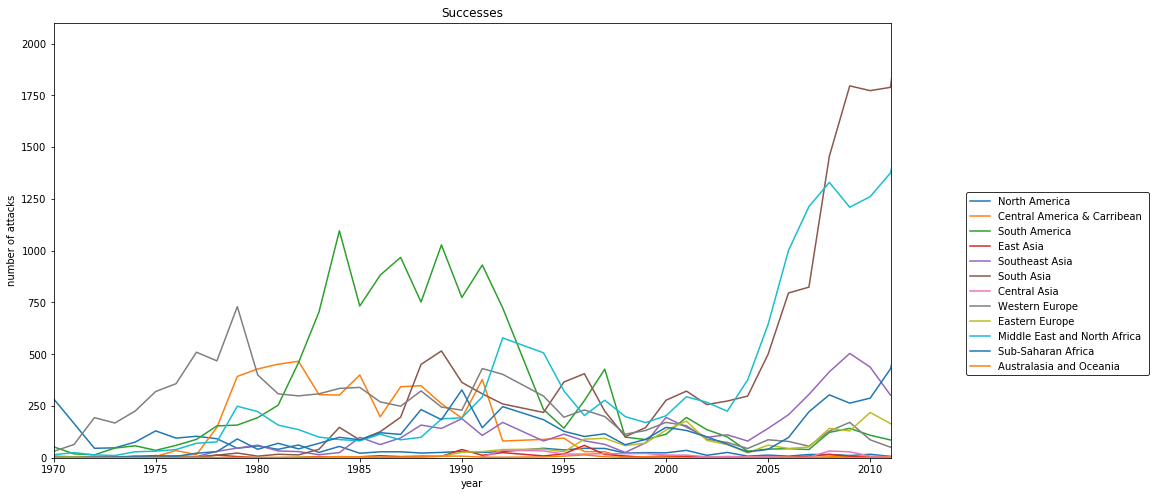

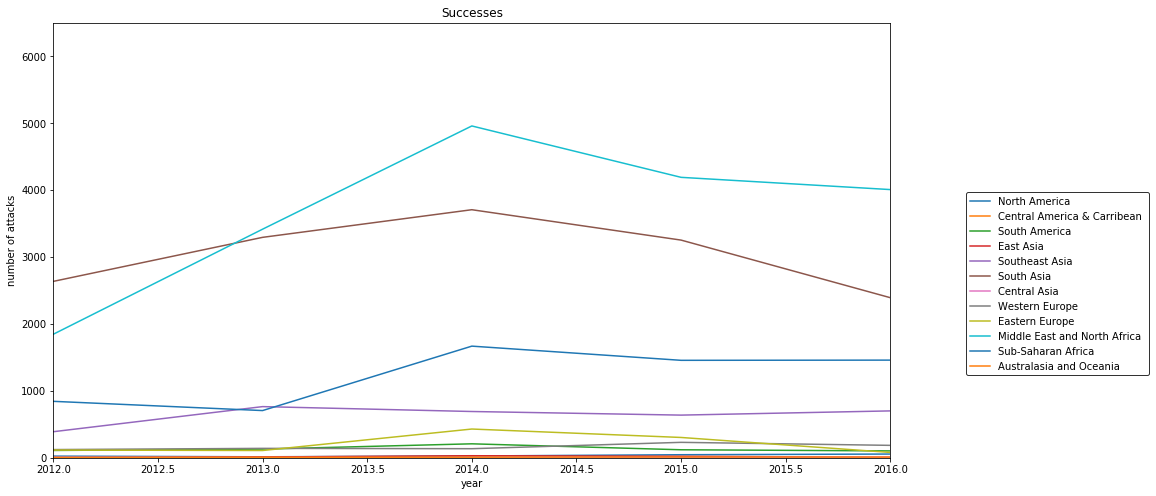

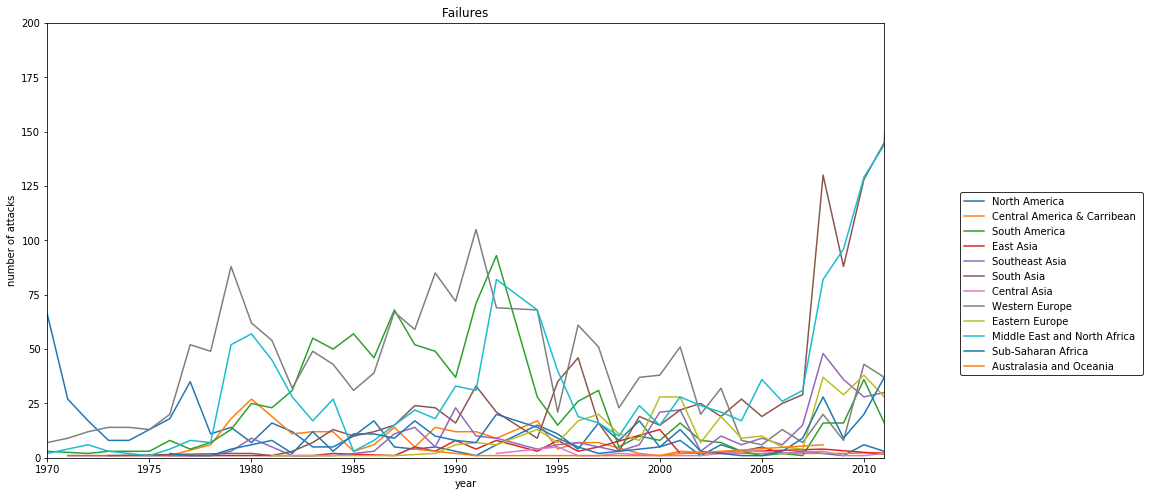

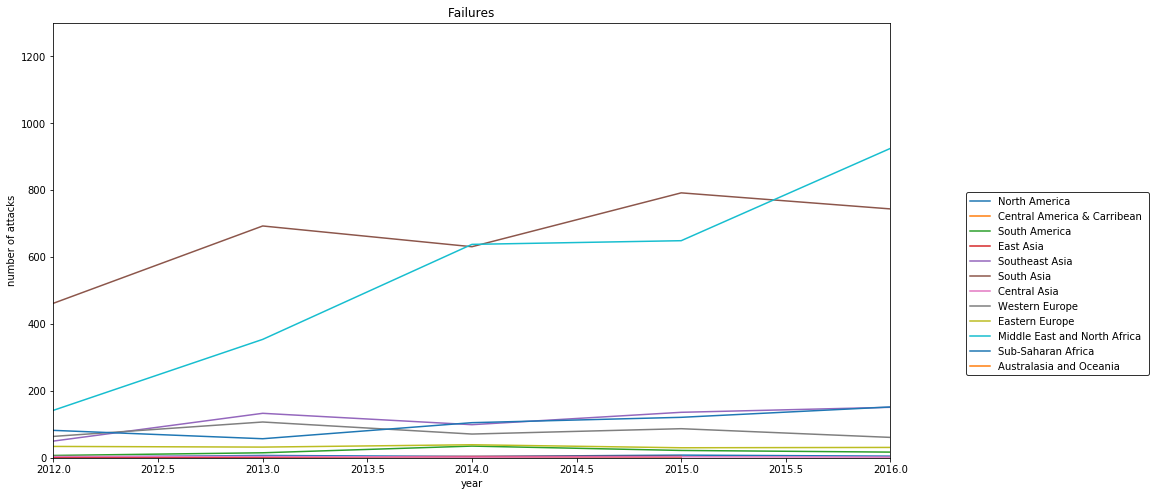

In [20]:
region_dictionary = {1: 'North America', 2: 'Central America & Carribean', 3: 'South America',
                     4: 'East Asia', 5: 'Southeast Asia', 6: 'South Asia', 7: 'Central Asia',
                     8: 'Western Europe', 9: 'Eastern Europe', 10: 'Middle East and North Africa',
                     11: 'Sub-Saharan Africa', 12: 'Australasia and Oceania'}

def multi_graph(result,result_list, xmin, xmax, ymin, ymax):
    fig2, ax2 = plt.subplots(figsize = (15,8))
    number = 1 #the for-loop in append_list processes the regions in order from 1 to 12
    for j in result_list:
        ax2.plot(j.index, j.eventid, label = '%s ' % region_dictionary[number] )
        number += 1

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('year')
    plt.ylabel('number of attacks')
    plt.title(result)
    ax2.legend(loc = 'center', frameon = True, edgecolor = 'black',bbox_to_anchor =(1.2,0.4))


success_list = []
failure_list = []

for i in region_dictionary:
    region_data = data[(data.region == i)]
    region_data_success = region_data[(region_data.success == 1)]
    region_data_failure = region_data[(region_data.success == 0)]
    region_grouped_success = region_data_success.groupby('iyear').count()
    region_grouped_failure = region_data_failure.groupby('iyear').count()

    
    success_list.append(region_grouped_success)
    failure_list.append(region_grouped_failure)

multi_graph('Successes',success_list, 1970, 2011, 0, 2100)
multi_graph('Successes',success_list, 2012, 2016, 0, 6500)
multi_graph('Failures',failure_list, 1970, 2011, 0, 200)
multi_graph('Failures',failure_list, 2012, 2016, 0, 1300)

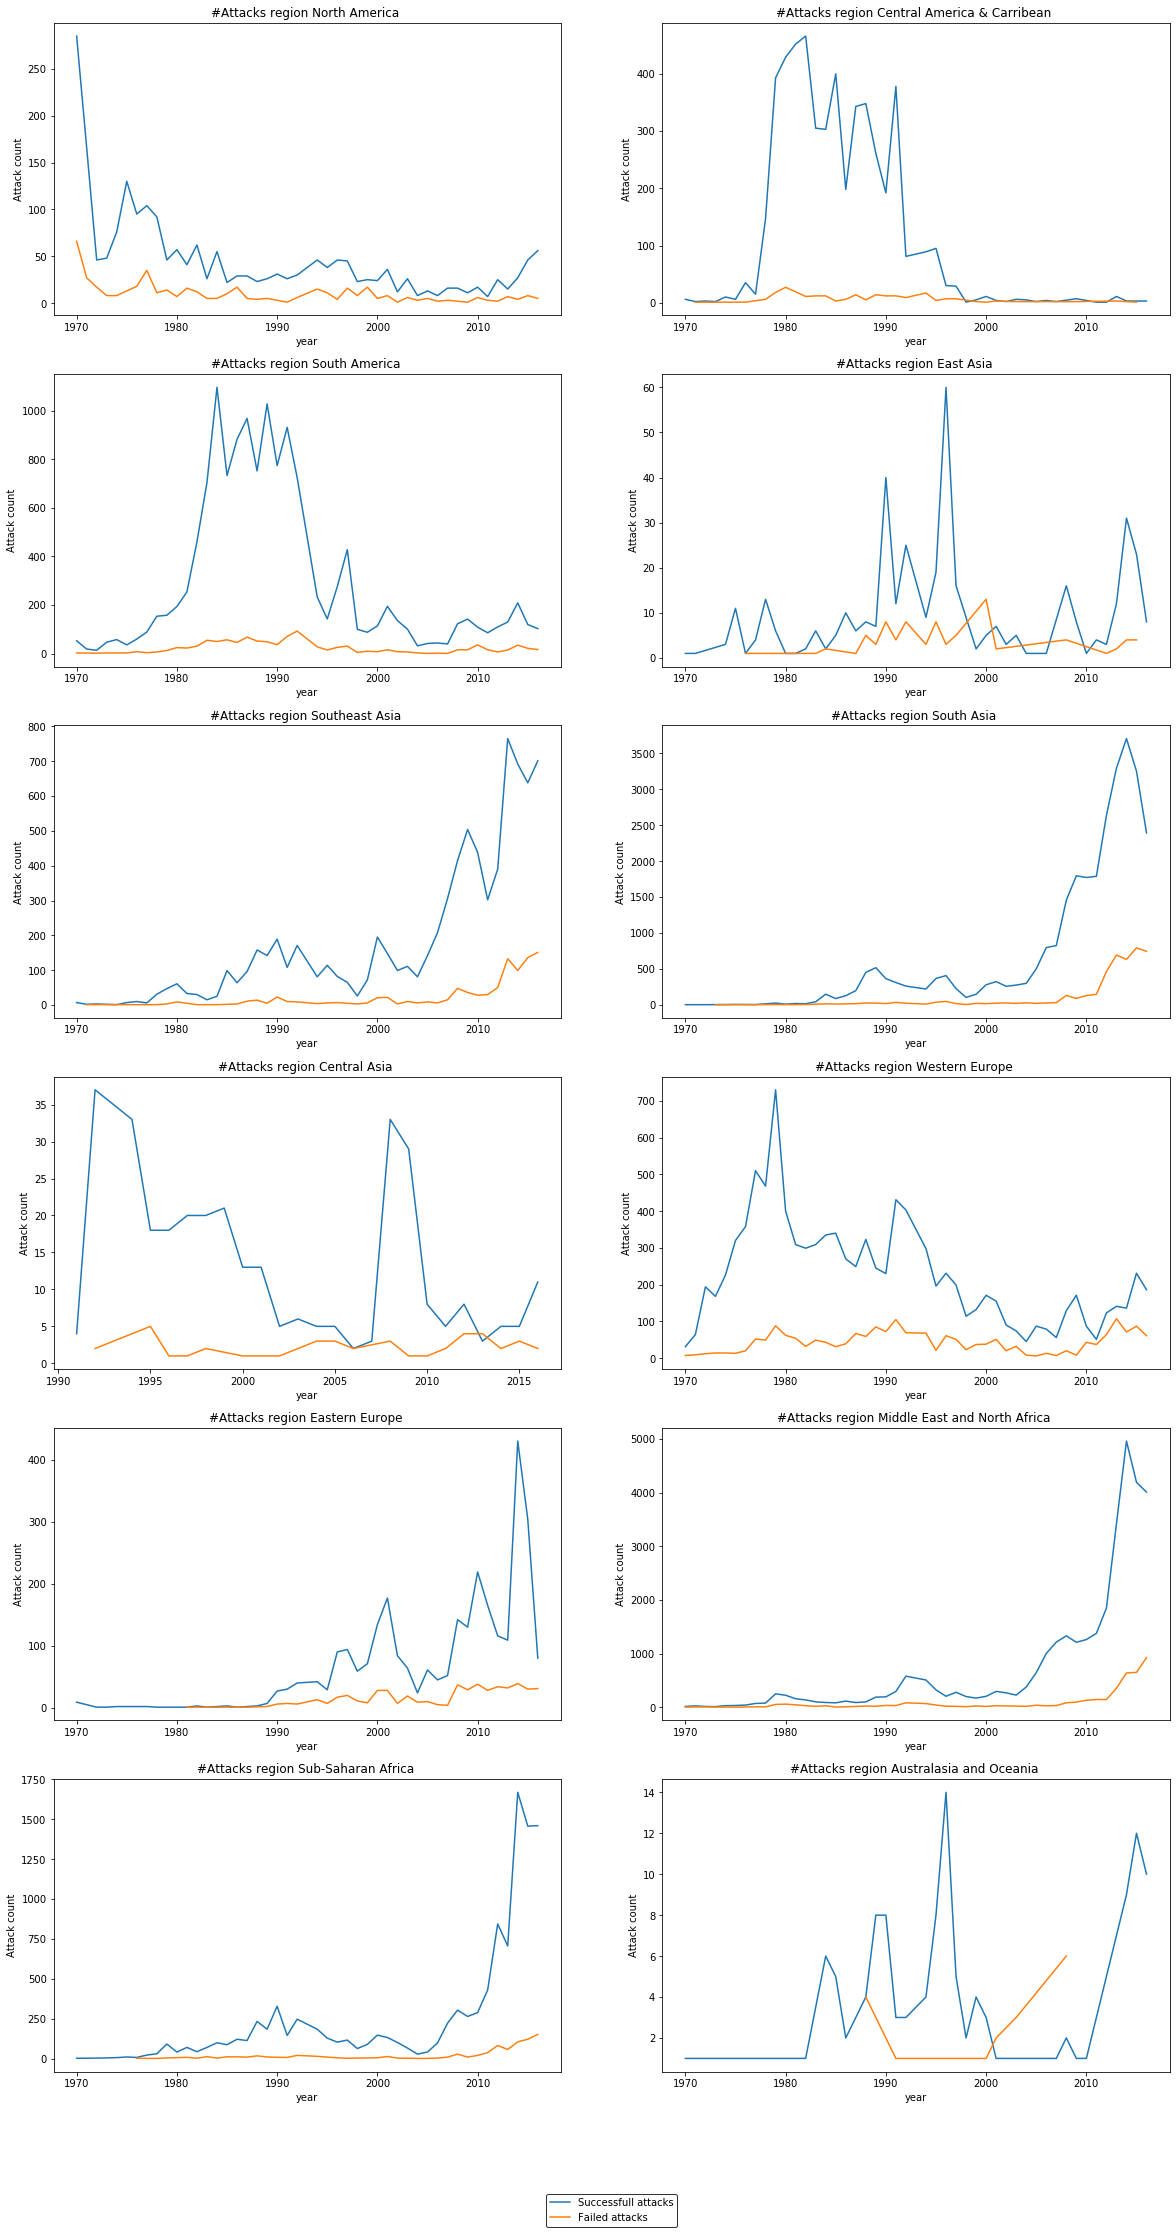

In [21]:
def generate_graph(by_region_list):
    fig = plt.figure(figsize=(20,70))
    i = 1
    
    for element in by_region_list:
        ax1 = fig.add_subplot(11,2,i)
        ax1.set(title = '#Attacks region %s ' % region_dictionary[element[2]],
                ylabel = 'Attack count', xlabel = 'year')

        #entering data
        ax1.plot(element[0].index, element[0].eventid, label = 'Successfull attacks' )
        ax1.plot(element[1].index, element[1].eventid, label = 'Failed attacks' )
        
        i+=1
    
    #add legend
    ax1.legend(loc = 'upper center', frameon = True, edgecolor = 'black', bbox_to_anchor =(-0.1,-0.4))
    plt.show()  


def by_region():
        for region_number in region_dictionary:
            region_data = data[(data.region == region_number)] #for each region group data by year
            region_grouped_success = region_data[(region_data.success == 1)].groupby('iyear').count() #filter on success and group by year
            region_grouped_failure = region_data[(region_data.success == 0)].groupby('iyear').count() #filter on failure and group by year
            
            by_region_list.append([region_grouped_success, region_grouped_failure, region_number])
        
        #create line plot for region grouped by year
        generate_graph(by_region_list)

by_region_list = []
by_region()

Text(0, 0.5, 'Attack type')

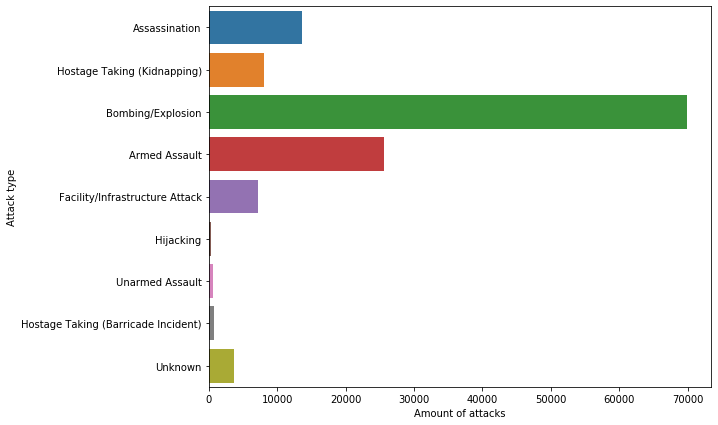

In [23]:
plt.figure(figsize=(9,7))
ax = sns.countplot(y="attacktype1_txt", data=data)
ax.set_xlabel("Amount of attacks")
ax.set_ylabel("Attack type")

In [24]:
# Load the dataset.
data_w = pd.read_csv('terrorist_weather_jan2012_dec_2016.csv', encoding='ISO-8859-1')

In [25]:
# This set has the same columns as the original dataset and has been cleaned in the same manner.
# Additionally, five weather condition columns were added, as described above.
data_w.head()

,iyear,imonth,iday,latitude,longitude,extended,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,claimed,property,ishostkid,nkill,nwound,country_txt,region_txt,attacktype1_txt,targtype1_txt,natlty1_txt,weaptype1_txt,target1,gname,summary,ncasualties,has_casualties,t2m,tcc,vidgf,sp,v10
0,2012,1,1,30.209423,67.018009,0,0,1,1,1,0,0,1,0,0.0,1,0.0,0,12,Pakistan,South Asia,Bombing/Explosion,Business,Pakistan,Explosives/Bombs/Dynamite,paan shop,unknown,01/01/2012: a grenade was thrown into a shop o...,12,1,288.217098,9.998669e-13,-366.496179,101457.723797,-3.828428
1,2012,1,1,-0.456120,39.646123,0,0,1,1,1,0,1,1,0,0.0,1,0.0,3,14,Kenya,Sub-Saharan Africa,Armed Assault,Business,Kenya,Explosives/Bombs/Dynamite,bar,al-shabaab,01/01/2012: assailants threw two grenades and ...,17,1,297.077670,1.530221e-01,606.077234,101103.215653,1.320113
2,2012,1,1,-0.456120,39.646123,0,0,1,1,1,0,1,1,0,0.0,1,0.0,2,14,Kenya,Sub-Saharan Africa,Armed Assault,Business,Kenya,Explosives/Bombs/Dynamite,bar,al-shabaab,01/01/2012: assailants threw a grenade and ope...,16,1,297.077670,1.530221e-01,606.077234,101103.215653,1.320113
3,2012,1,1,28.466667,67.283333,1,0,1,1,1,0,0,1,0,0.0,0,1.0,0,0,Pakistan,South Asia,Hostage Taking (Kidnapping),Private Citizens & Property,Pakistan,Firearms,civilians,unknown,01/01/2012: four men were kidnapped from their...,0,0,287.513173,9.998669e-13,-17.655798,100755.508624,-3.728933
4,2012,1,1,34.761723,71.324719,0,0,1,1,1,0,0,1,0,0.0,1,0.0,1,3,Pakistan,South Asia,Bombing/Explosion,Terrorists/Non-State Militia,Pakistan,Explosives/Bombs/Dynamite,militia members,unknown,01/01/2012: an explosive device targeting anti...,4,1,269.929184,9.998669e-13,62.722170,79226.577609,0.577216


In [26]:
# Define X and y.
X = data_w[['t2m', 'tcc', 'vidgf', 'sp', 'v10']].fillna(0) # Features
y = data_w['has_casualties'].fillna(0) # Target

X.shape, y.shape

((53715, 5), (53715,))

In [27]:
# Count the number of attacks that have at least 1 casualty and those that don't.
y.value_counts()

1    36396
0    17319
Name: has_casualties, dtype: int64

In [28]:
# Split into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Use SVM as classifier.
model = svm.SVC()

# Fit the model with training sets.
%time model.fit(X_train, y_train)

# Predict wether there are casualties or not.
%time y_pred = model.predict(X_test)

C:\Users\amits\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 3min 40s
Wall time: 32 s


In [29]:
np.mean(y_pred == y_test)

0.7260937015203227

In [30]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
model = DummyClassifier(strategy="most_frequent")

%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

Wall time: 2 ms
Wall time: 0 ns


0.6703071672354949

In [31]:
feature_cols = [
    'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
                'extended',
                'vicinity',
                'doubtterr',
                'multiple',
                'success',
                'suicide',
                'claimed',
                'property',
                'ishostkid',
    
                'country_txt',
                'region',
                'attacktype1_txt',
                'targtype1_txt',
                'weaptype1_txt',
]
# Target is a binary value: were there any casualties in the attack?
target_col = 'has_casualties'

lb = LabelEncoder()
data['country_txt'] = lb.fit_transform(data['country_txt'])
data['attacktype1_txt'] = lb.fit_transform(data['attacktype1_txt'])
data['targtype1_txt'] = lb.fit_transform(data['targtype1_txt'])
data['weaptype1_txt'] = lb.fit_transform(data['weaptype1_txt'])

# Define X and Y.
X = data[feature_cols].fillna(0)
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

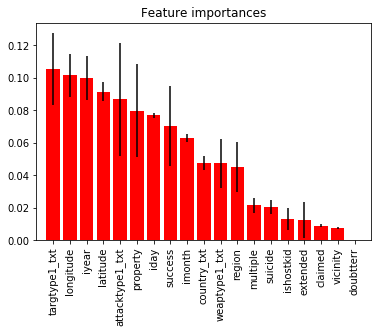

In [32]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
fnames = [feature_cols[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), fnames, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [33]:
feature_cols = ['longitude', 'targtype1_txt', 'latitude', 'attacktype1_txt', 'success', 'property', 'country_txt', 'weaptype1_txt', 'region']

X = data[feature_cols].fillna(0) # Assign chosen features to X.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
model = RandomForestClassifier(n_estimators=20)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

0.8293609051491906

Confusion matrix, without normalization
[[13166  3307]
 [ 3344 19160]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.15 0.85]]


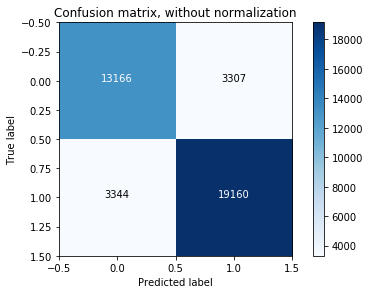

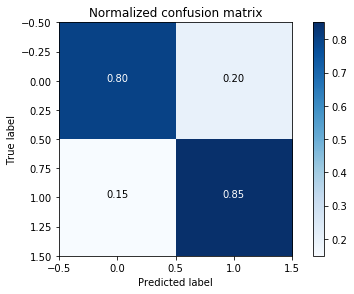

In [35]:
cnf_matrix = confusion_matrix(y_test, y_pred)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

In [36]:
# Better validation with K-fold.
model = RandomForestClassifier(n_estimators=20)

scores = cross_val_score(model, X, y, cv=10) # Ten-fold cross validation.
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[0.74 0.74 0.72 0.8  0.77 0.76 0.8  0.78 0.79 0.81]
Accuracy: 0.77 (+/- 0.06)


In [37]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
model = DummyClassifier(strategy="most_frequent")

%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

Wall time: 6.98 ms
Wall time: 0 ns


0.5773661390050543

In [ ]:
#Supplied with the chosen features, the Random Forest classifier achieves an accuracy score of 0.77.
#The baseline accuracy is 0.58.